In [22]:
import lbforaging
import numpy as np
import time
import matplotlib.pyplot as plt
import gymnasium as gym

from games.foraging import Foraging
from agents.iql import Iql
from agents.jalam import Jalam

In [39]:
configurations = {
    '0' : {
        'game': "Foraging-5x5-2p-1f-v3",
        'game_seed': 22,
        'agent_config': {
            'lr': 0.01,
            'epsilon_min': 0.01,
            'epsilon_steps': 5000,
            'discount': 1,
            'seed': 1

        },
        'train_config': {
            'episodes': 100,
            'iterations': 50,
        }
    },
    '1' : {
        'game': "Foraging-5x5-2p-1f-v3",
        'game_seed': 13,
        'agent_config': {
            'lr': 0.01,
            'epsilon_min': 0.01,
            'epsilon_steps': 10000,
            'discount': 1,
            'seed': 1

        },
        'train_config': {
            'episodes': 100,
            'iterations': 100,
        }
    },
    '2' : {
        'game': "Foraging-5x5-2p-1f-coop-v3",
        'game_seed': 10,
        'agent_config': {
            'lr': 0.01,
            'epsilon_min': 0.01,
            'epsilon_steps': 10000,
            'discount': 1,
            'seed': 1
        },
        'train_config': {
            'episodes': 100,
            'iterations': 100,
        }
    },
    '3' : {
            'game': "Foraging-5x5-3p-1f-v3",
            'game_seed': 30,
            'agent_config': {
                'lr': 0.01,
                'epsilon_min': 0.01,
                'epsilon_steps': 25000,
                'discount': 0.99,
                'seed': 1

            },
            'train_config': {
                'episodes': 400,
                'iterations': 100,
            }
        },
    '4' : {
        'game': "Foraging-5x5-3p-1f-coop-v3",
        'game_seed': 2,
        'agent_config': {
            'lr': 0.01,
            'epsilon_min': 0.01,
            'epsilon_steps': 25000,
            'discount': 1,
            'seed': 1

        },
        'train_config': {
            'episodes': 300,
            'iterations': 100,
        }
    },
    '5' : {
        'game': "Foraging-8x8-3p-1f-coop-v3",
        'game_seed': 10,
        'agent_config': {
            'lr': 0.01,
            'epsilon_min': 0.01,
            'epsilon_steps': 800000,
            'discount': 1,
            'seed': 1

        },
        'train_config': {
            'episodes': 1000,
            'iterations': 100,
        }
    }
}

In [24]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))

    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].step_update()
    
    return cum_rewards

In [25]:
def run(game, agents, episodes=1, verbose=False, render=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    for _ in range(episodes):
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)  
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")  
    return sum_rewards     

In [26]:
def train(game, agents, train_config, progress=False, verbose=False, render=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    average_rewards = dict(map(lambda agent: (agent, []), game.agents))
    for i in range(1, iterations+1):
        sum_rewards = run(game, agents, episodes=episodes, verbose=verbose, render=render)
        for agent in game.agents:
            average_rewards[agent].append(sum_rewards[agent] / episodes)
        if progress and (i % 10 == 0):
            print(f"Iteration {i} ({i * episodes} episodes)")
            for agent in game.agents:
                print(f"Agent {agent}: {average_rewards[agent][-1]}")
    if progress:
        print(f"Last average rewards over {iterations} iterations ({iterations * episodes} episodes):")
        for agent in game.agents:
            print(f"Agent {agent}: {average_rewards[agent][-1]}")
    return average_rewards

In [27]:
def run_config(config, cls):
    config = configurations[config]
    game = Foraging(config=config['game'], seed=config['game_seed'])
    agents = {}
    for i, agent in enumerate(game.agents):
        agents[agent] = cls[i](game=game, agent=agent, **config['agent_config'])

    plt.imshow(game.render_start_array())
    plt.axis('off')
    plt.show()

    average_rewards = train(game, agents, train_config=config['train_config'], progress=True, verbose=False, render=False)

    for agent, rewards in average_rewards.items():
        plt.plot(rewards, label=agent)

    plt.xlabel('Iterations')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards per Agent')
    plt.legend()
    plt.show()

    for agent in game.agents:
        agents[agent].learn = False

    play_episode(game, agents, verbose=True, render=False)



### IQL vs IQL

#### Ambiente 5x5 donde ambos pueden levantar la fruta y estan a la misma distancia

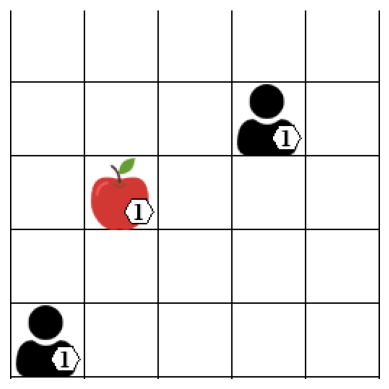

Iteration 10 (1000 episodes)
Agent agent_0: 0.52
Agent agent_1: 0.48
Iteration 20 (2000 episodes)
Agent agent_0: 0.485
Agent agent_1: 0.515
Iteration 30 (3000 episodes)
Agent agent_0: 0.49
Agent agent_1: 0.51
Iteration 40 (4000 episodes)
Agent agent_0: 0.53
Agent agent_1: 0.47
Iteration 50 (5000 episodes)
Agent agent_0: 0.5
Agent agent_1: 0.5
Last average rewards over 50 iterations (5000 episodes):
Agent agent_0: 0.5
Agent agent_1: 0.5


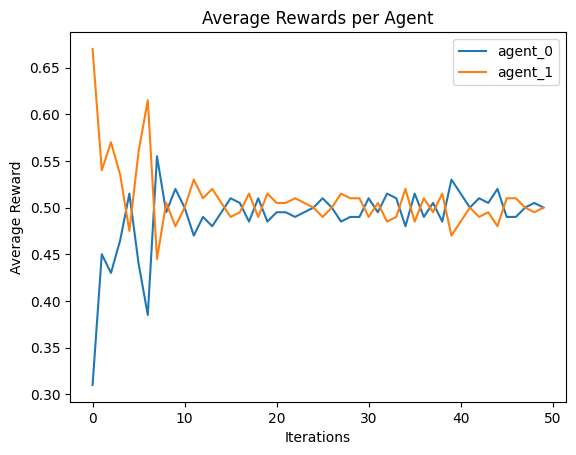

Step: 0
Agent agent_0 observe: [2. 1. 1. 1. 3. 1. 4. 0. 1.]
Agent agent_1 observe: [2. 1. 1. 4. 0. 1. 1. 3. 1.]
Step: 1
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [2. 1. 1. 1. 2. 1. 4. 1. 1.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [2. 1. 1. 4. 1. 1. 1. 2. 1.]
Step: 2
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [2. 1. 1. 2. 2. 1. 3. 1. 1.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [2. 1. 1. 3. 1. 1. 2. 2. 1.]
Step: 3
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 0.5
Agent agent_0 observe: [-1. -1.  0.  2.  2.  1.  3.  1.  1.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 0.5
Agent agent_1 observe: [-1. -1.  0.  3.  1.  1.  2.  2.  1.]


In [28]:
run_config('0', [Iql, Iql])

#### Ambiente 5x5 donde ambos pueden levantar la fruta pero se encuentran a distancias distintas de la fruta

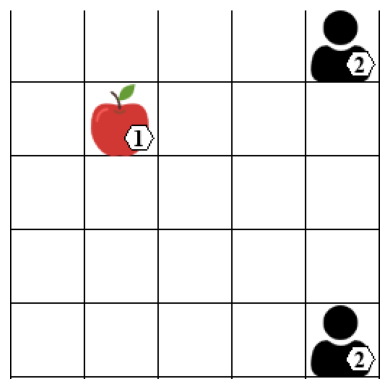

Iteration 10 (1000 episodes)
Agent agent_0: 0.07
Agent agent_1: 0.93
Iteration 20 (2000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 30 (3000 episodes)
Agent agent_0: 0.0
Agent agent_1: 1.0
Iteration 40 (4000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 50 (5000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 60 (6000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 70 (7000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 80 (8000 episodes)
Agent agent_0: 0.02
Agent agent_1: 0.98
Iteration 90 (9000 episodes)
Agent agent_0: 0.0
Agent agent_1: 1.0
Iteration 100 (10000 episodes)
Agent agent_0: 0.0
Agent agent_1: 1.0
Last average rewards over 100 iterations (10000 episodes):
Agent agent_0: 0.0
Agent agent_1: 1.0


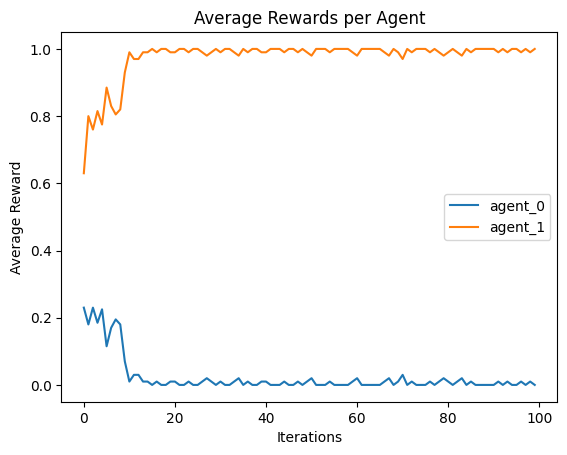

Step: 0
Agent agent_0 observe: [1. 1. 1. 4. 4. 2. 0. 4. 2.]
Agent agent_1 observe: [1. 1. 1. 0. 4. 2. 4. 4. 2.]
Step: 1
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 4. 3. 2. 0. 3. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 0. 3. 2. 4. 3. 2.]
Step: 2
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 3. 3. 2. 1. 3. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 1. 3. 2. 3. 3. 2.]
Step: 3
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 2. 3. 2. 1. 2. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 1. 2. 2. 2. 3. 2.]
Step: 4
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [-1. -1.  0.  2.  2.  2.  1.  2.  2.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 1.0
Agent agent_1 observe: [-1. -1.  0.  1

In [29]:
run_config('1', [Iql, Iql])

#### Ambiente 5x5, coperativo

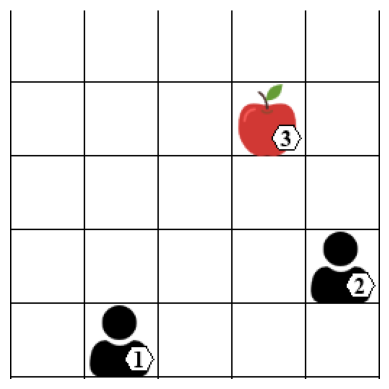

Iteration 10 (1000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 20 (2000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 30 (3000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 40 (4000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 50 (5000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 60 (6000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 70 (7000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 80 (8000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 90 (9000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 100 (10000 episodes)
Agent agent_0: 0.32999999999999957
Agent agent_1: 0.6599999999999991
Last average rewards over 1

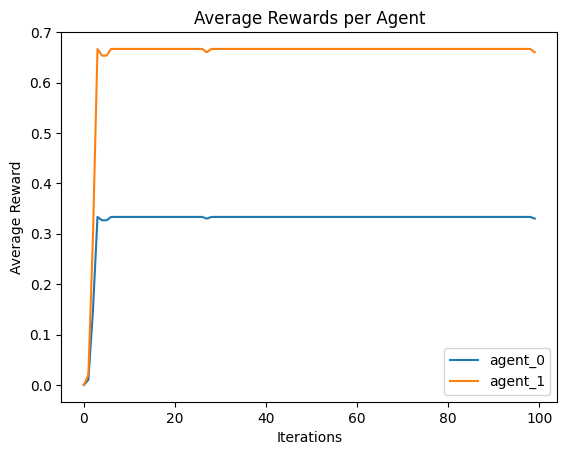

Step: 0
Agent agent_0 observe: [1. 3. 3. 4. 1. 1. 3. 4. 2.]
Agent agent_1 observe: [1. 3. 3. 3. 4. 2. 4. 1. 1.]
Step: 1
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 4. 1. 1. 2. 4. 2.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 2. 4. 2. 4. 1. 1.]
Step: 2
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 3. 1. 1. 1. 4. 2.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 1. 4. 2. 3. 1. 1.]
Step: 3
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 2. 1. 1. 2. 4. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 2. 4. 2. 2. 1. 1.]
Step: 4
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 1. 1. 1. 2. 4. 2.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 2. 4. 2. 1. 1

In [30]:
run_config('2', [Iql, Iql])

#### Ambiente 5x5, 3 jugadores, mixto

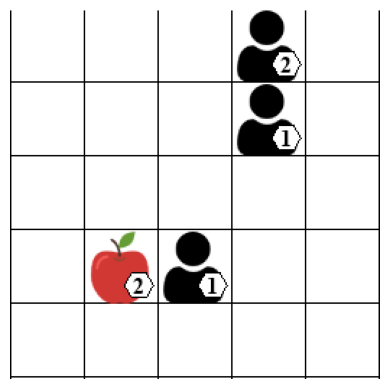

Iteration 10 (4000 episodes)
Agent agent_0: 0.42708333333333326
Agent agent_1: 0.006666666666666666
Agent agent_2: 0.42625
Iteration 20 (8000 episodes)
Agent agent_0: 0.010833333333333335
Agent agent_1: 0.659999999999997
Agent agent_2: 0.324166666666665
Iteration 30 (12000 episodes)
Agent agent_0: 0.09458333333333332
Agent agent_1: 0.07333333333333336
Agent agent_2: 0.11458333333333334
Iteration 40 (16000 episodes)
Agent agent_0: 0.3120833333333333
Agent agent_1: 0.0125
Agent agent_2: 0.3154166666666667
Iteration 50 (20000 episodes)
Agent agent_0: 0.3045833333333333
Agent agent_1: 0.0525
Agent agent_2: 0.3104166666666666
Iteration 60 (24000 episodes)
Agent agent_0: 0.24875
Agent agent_1: 0.485
Agent agent_2: 0.25125
Iteration 70 (28000 episodes)
Agent agent_0: 0.255625
Agent agent_1: 0.49291666666666656
Agent agent_2: 0.25145833333333334
Iteration 80 (32000 episodes)
Agent agent_0: 0.25854166666666667
Agent agent_1: 0.48291666666666666
Agent agent_2: 0.25604166666666667
Iteration 90 (3

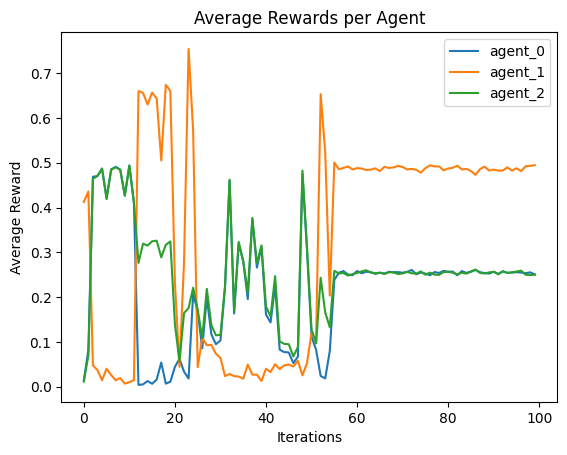

Step: 0
Agent agent_0 observe: [3. 1. 2. 3. 2. 1. 0. 3. 2. 1. 3. 1.]
Agent agent_1 observe: [3. 1. 2. 0. 3. 2. 3. 2. 1. 1. 3. 1.]
Agent agent_2 observe: [3. 1. 2. 1. 3. 1. 3. 2. 1. 0. 3. 2.]
Step: 1
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 4. 2. 1. 1. 3. 2. 2. 3. 1.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 3. 2. 4. 2. 1. 2. 3. 1.]
Agent agent_2 action: 2 - SOUTH
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 1. 2. 2. 3. 1. 4. 2. 1. 1. 3. 2.]
Step: 2
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 4. 2. 1. 1. 2. 2. 2. 2. 1.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 2. 2. 4. 2. 1. 2. 2. 1.]
Agent agent_2 action: 3 - WEST
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 1. 2. 2. 2. 1. 4. 2. 1. 1. 2. 2.]
Step: 3
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 

In [41]:
run_config('3', [Iql, Iql, Iql])

#### Ambiente 5x5, 3 jugadores, coperativo

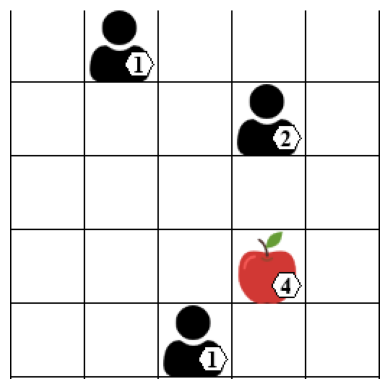

Iteration 10 (3000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.0
Agent agent_2: 0.0
Iteration 20 (6000 episodes)
Agent agent_0: 0.24166666666666667
Agent agent_1: 0.24166666666666667
Agent agent_2: 0.48333333333333334
Iteration 30 (9000 episodes)
Agent agent_0: 0.24916666666666668
Agent agent_1: 0.24916666666666668
Agent agent_2: 0.49833333333333335
Iteration 40 (12000 episodes)
Agent agent_0: 0.24916666666666668
Agent agent_1: 0.24916666666666668
Agent agent_2: 0.49833333333333335
Iteration 50 (15000 episodes)
Agent agent_0: 0.24916666666666668
Agent agent_1: 0.24916666666666668
Agent agent_2: 0.49833333333333335
Iteration 60 (18000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 70 (21000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 80 (24000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 90 (27000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 100 (30000

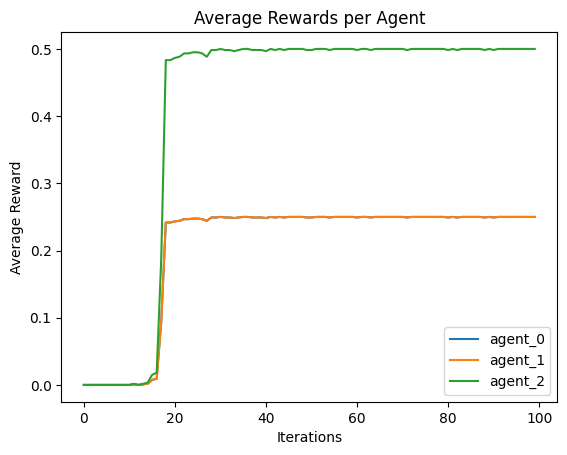

Step: 0
Agent agent_0 observe: [3. 3. 4. 0. 1. 1. 4. 2. 1. 1. 3. 2.]
Agent agent_1 observe: [3. 3. 4. 4. 2. 1. 0. 1. 1. 1. 3. 2.]
Agent agent_2 observe: [3. 3. 4. 1. 3. 2. 0. 1. 1. 4. 2. 1.]
Step: 1
Agent agent_0 action: 4 - EAST
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 4. 0. 2. 1. 4. 2. 1. 1. 4. 2.]
Agent agent_1 action: 0 - NONE
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 3. 4. 4. 2. 1. 0. 2. 1. 1. 4. 2.]
Agent agent_2 action: 4 - EAST
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 3. 4. 1. 4. 2. 0. 2. 1. 4. 2. 1.]
Step: 2
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 4. 1. 2. 1. 4. 3. 1. 1. 4. 2.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 3. 4. 4. 3. 1. 1. 2. 1. 1. 4. 2.]
Agent agent_2 action: 5 - LOAD
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 3. 4. 1. 4. 2. 1. 2. 1. 4. 3. 1.]
Step: 3
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 4.

In [32]:
run_config('4', [Iql, Iql, Iql])

### JAL-AM vs JAL-AM

#### Ambiente 5x5 donde ambos pueden levantar la fruta y estan a la misma distancia

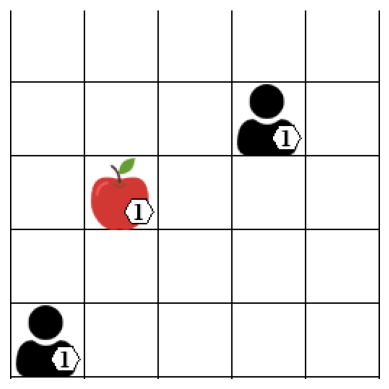

Iteration 10 (1000 episodes)
Agent agent_0: 0.495
Agent agent_1: 0.505
Iteration 20 (2000 episodes)
Agent agent_0: 0.49
Agent agent_1: 0.51
Iteration 30 (3000 episodes)
Agent agent_0: 0.495
Agent agent_1: 0.505
Iteration 40 (4000 episodes)
Agent agent_0: 0.51
Agent agent_1: 0.49
Iteration 50 (5000 episodes)
Agent agent_0: 0.5
Agent agent_1: 0.5
Last average rewards over 50 iterations (5000 episodes):
Agent agent_0: 0.5
Agent agent_1: 0.5


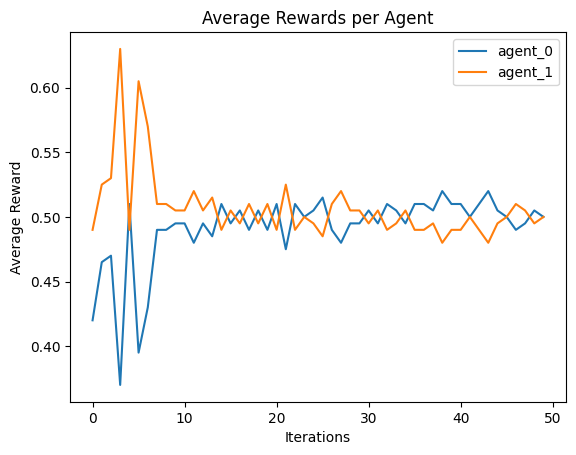

Step: 0
Agent agent_0 observe: [2. 1. 1. 1. 3. 1. 4. 0. 1.]
Agent agent_1 observe: [2. 1. 1. 4. 0. 1. 1. 3. 1.]
Step: 1
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [2. 1. 1. 2. 3. 1. 3. 0. 1.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [2. 1. 1. 3. 0. 1. 2. 3. 1.]
Step: 2
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [2. 1. 1. 2. 2. 1. 2. 0. 1.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [2. 1. 1. 2. 0. 1. 2. 2. 1.]
Step: 3
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 0.5
Agent agent_0 observe: [-1. -1.  0.  2.  2.  1.  2.  0.  1.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 0.5
Agent agent_1 observe: [-1. -1.  0.  2.  0.  1.  2.  2.  1.]


In [33]:
run_config('0', [Jalam, Jalam])

#### Ambiente 5x5 donde ambos pueden levantar la fruta pero se encuentran a distancias distintas de la fruta

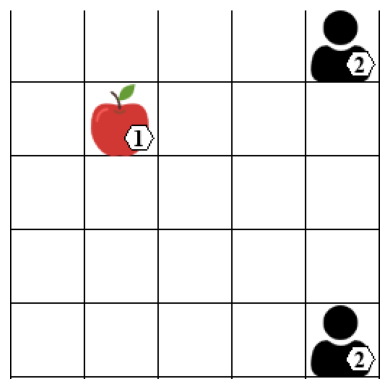

Iteration 10 (1000 episodes)
Agent agent_0: 0.08
Agent agent_1: 0.92
Iteration 20 (2000 episodes)
Agent agent_0: 0.0
Agent agent_1: 1.0
Iteration 30 (3000 episodes)
Agent agent_0: 0.005
Agent agent_1: 0.995
Iteration 40 (4000 episodes)
Agent agent_0: 0.0
Agent agent_1: 1.0
Iteration 50 (5000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 60 (6000 episodes)
Agent agent_0: 0.01
Agent agent_1: 0.99
Iteration 70 (7000 episodes)
Agent agent_0: 0.005
Agent agent_1: 0.995
Iteration 80 (8000 episodes)
Agent agent_0: 0.005
Agent agent_1: 0.995
Iteration 90 (9000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.99
Iteration 100 (10000 episodes)
Agent agent_0: 0.015
Agent agent_1: 0.985
Last average rewards over 100 iterations (10000 episodes):
Agent agent_0: 0.015
Agent agent_1: 0.985


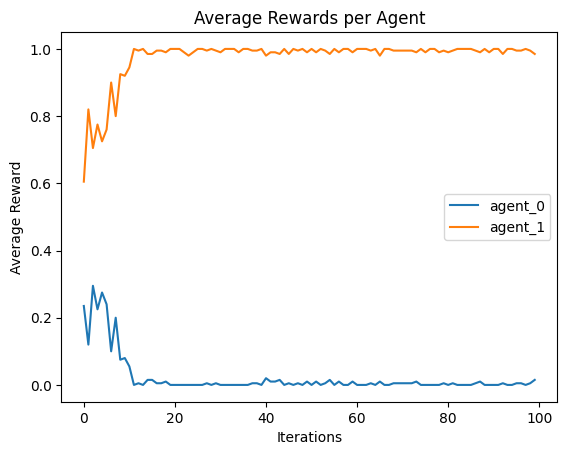

Step: 0
Agent agent_0 observe: [1. 1. 1. 4. 4. 2. 0. 4. 2.]
Agent agent_1 observe: [1. 1. 1. 0. 4. 2. 4. 4. 2.]
Step: 1
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 3. 4. 2. 0. 3. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 0. 3. 2. 3. 4. 2.]
Step: 2
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 3. 3. 2. 1. 3. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 1. 3. 2. 3. 3. 2.]
Step: 3
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 3. 2. 2. 1. 2. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 1. 2. 2. 3. 2. 2.]
Step: 4
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [-1. -1.  0.  2.  2.  2.  1.  2.  2.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 1.0
Agent agent_1 observe: [-1. -1.  0.  1

In [34]:
run_config('1', [Jalam, Jalam])

#### Ambiente 5x5, coperativo

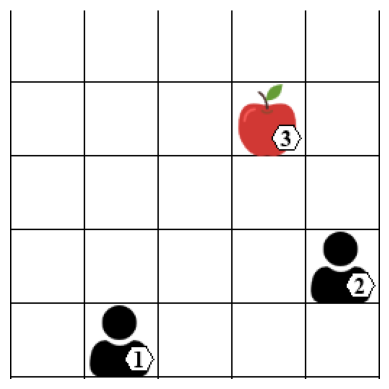

Iteration 10 (1000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 20 (2000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 30 (3000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 40 (4000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 50 (5000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 60 (6000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 70 (7000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 80 (8000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 90 (9000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Iteration 100 (10000 episodes)
Agent agent_0: 0.3333333333333329
Agent agent_1: 0.6666666666666659
Last average rewards over 10

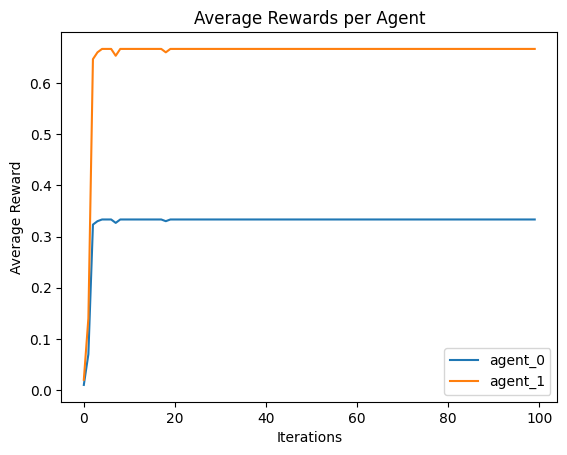

Step: 0
Agent agent_0 observe: [1. 3. 3. 4. 1. 1. 3. 4. 2.]
Agent agent_1 observe: [1. 3. 3. 3. 4. 2. 4. 1. 1.]
Step: 1
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 3. 1. 1. 3. 4. 2.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 3. 4. 2. 3. 1. 1.]
Step: 2
Agent agent_0 action: 4 - EAST
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 3. 2. 1. 3. 3. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 3. 3. 2. 3. 2. 1.]
Step: 3
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 2. 2. 1. 3. 4. 2.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 3. 4. 2. 2. 2. 1.]
Step: 4
Agent agent_0 action: 1 - NORTH
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 3. 3. 1. 2. 1. 3. 3. 2.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 3. 3. 3. 3. 2. 1. 2. 1

In [35]:
run_config('2', [Jalam, Jalam])

#### Ambiente 5x5, 3 jugadores, mixto

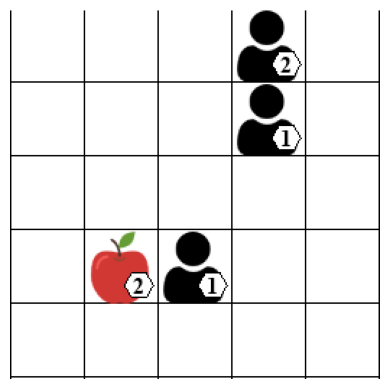

Iteration 10 (4000 episodes)
Agent agent_0: 0.254166666666666
Agent agent_1: 0.483333333333332
Agent agent_2: 0.0175
Iteration 20 (8000 episodes)
Agent agent_0: 0.028333333333333332
Agent agent_1: 0.04666666666666666
Agent agent_2: 0.02
Iteration 30 (12000 episodes)
Agent agent_0: 0.49583333333333335
Agent agent_1: 0.016666666666666666
Agent agent_2: 0.4875
Iteration 40 (16000 episodes)
Agent agent_0: 0.4933333333333333
Agent agent_1: 0.01916666666666667
Agent agent_2: 0.4875
Iteration 50 (20000 episodes)
Agent agent_0: 0.49500000000000005
Agent agent_1: 0.02
Agent agent_2: 0.485
Iteration 60 (24000 episodes)
Agent agent_0: 0.4958333333333334
Agent agent_1: 0.011666666666666665
Agent agent_2: 0.49
Iteration 70 (28000 episodes)
Agent agent_0: 0.49625
Agent agent_1: 0.015
Agent agent_2: 0.48875
Iteration 80 (32000 episodes)
Agent agent_0: 0.49458333333333326
Agent agent_1: 0.01916666666666667
Agent agent_2: 0.48625
Iteration 90 (36000 episodes)
Agent agent_0: 0.4958333333333334
Agent age

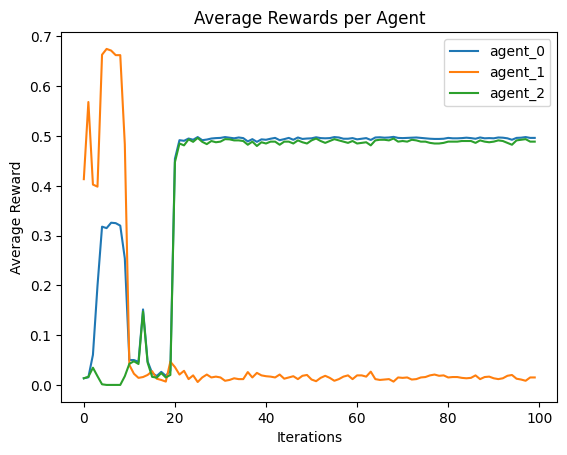

Step: 0
Agent agent_0 observe: [3. 1. 2. 3. 2. 1. 0. 3. 2. 1. 3. 1.]
Agent agent_1 observe: [3. 1. 2. 0. 3. 2. 3. 2. 1. 1. 3. 1.]
Agent agent_2 observe: [3. 1. 2. 1. 3. 1. 3. 2. 1. 0. 3. 2.]
Step: 1
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 0.0
Agent agent_0 observe: [3. 1. 2. 3. 2. 1. 0. 2. 2. 0. 3. 1.]
Agent agent_1 action: 3 - WEST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 2. 2. 3. 2. 1. 0. 3. 1.]
Agent agent_2 action: 1 - NORTH
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 1. 2. 0. 3. 1. 3. 2. 1. 0. 2. 2.]
Step: 2
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 3. 2. 1. 1. 2. 2. 0. 2. 1.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 2. 2. 3. 2. 1. 0. 2. 1.]
Agent agent_2 action: 3 - WEST
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 1. 2. 0. 2. 1. 3. 2. 1. 1. 2. 2.]
Step: 3
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 

In [42]:
run_config('3', [Jalam, Jalam, Jalam])

#### Ambiente 5x5, 3 jugadores, coperativo

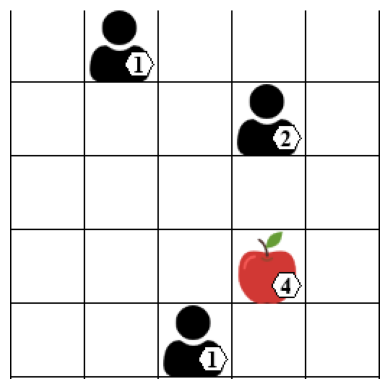

Iteration 10 (3000 episodes)
Agent agent_0: 0.24916666666666668
Agent agent_1: 0.24916666666666668
Agent agent_2: 0.49833333333333335
Iteration 20 (6000 episodes)
Agent agent_0: 0.24916666666666668
Agent agent_1: 0.24916666666666668
Agent agent_2: 0.49833333333333335
Iteration 30 (9000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 40 (12000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 50 (15000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 60 (18000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 70 (21000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 80 (24000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 90 (27000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Iteration 100 (30000 episodes)
Agent agent_0: 0.25
Agent agent_1: 0.25
Agent agent_2: 0.5
Last average rewards

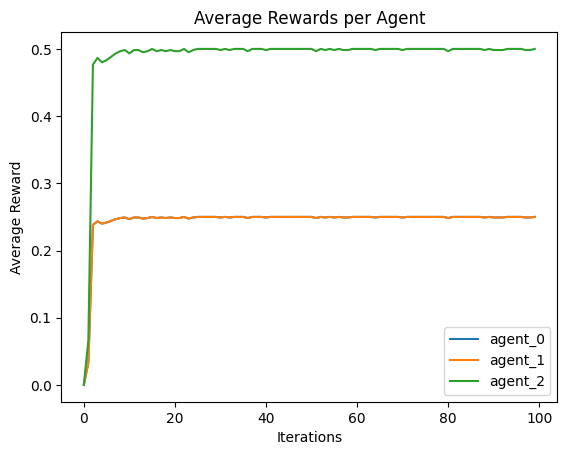

Step: 0
Agent agent_0 observe: [3. 3. 4. 0. 1. 1. 4. 2. 1. 1. 3. 2.]
Agent agent_1 observe: [3. 3. 4. 4. 2. 1. 0. 1. 1. 1. 3. 2.]
Agent agent_2 observe: [3. 3. 4. 1. 3. 2. 0. 1. 1. 4. 2. 1.]
Step: 1
Agent agent_0 action: 0 - NONE
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 4. 0. 1. 1. 4. 2. 1. 1. 4. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 3. 4. 4. 2. 1. 0. 1. 1. 1. 4. 2.]
Agent agent_2 action: 4 - EAST
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 3. 4. 1. 4. 2. 0. 1. 1. 4. 2. 1.]
Step: 2
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 4. 1. 1. 1. 4. 3. 1. 2. 4. 2.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 3. 4. 4. 3. 1. 1. 1. 1. 2. 4. 2.]
Agent agent_2 action: 2 - SOUTH
Agent agent_2 reward: 0
Agent agent_2 observe: [3. 3. 4. 2. 4. 2. 1. 1. 1. 4. 3. 1.]
Step: 3
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 3. 

In [37]:
run_config('4', [Jalam, Jalam, Jalam])